In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.3 MB/s 
     |████████████████████████████████| 186 kB 46.4 MB/s 
     |████████████████████████████████| 46 kB 4.0 MB/s 
     |████████████████████████████████| 1.2 MB 33.0 MB/s 
     |████████████████████████████████| 56 kB 3.8 MB/s 
     |████████████████████████████████| 51 kB 282 kB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

## Data Exploration

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)

In [4]:
#hide
Path.BASE_PATH = path

In [5]:
path.ls()

(#3) [Path('train'),Path('valid'),Path('labels.csv')]

In [6]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

In [7]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [8]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [9]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [10]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [11]:
#hide_output
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


### Baseline Model: Pixel Similarity (Classical Approach)

In [12]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

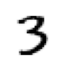

In [13]:
show_image(three_tensors[1]);

In [14]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [15]:
len(stacked_threes.shape)

3

In [16]:
stacked_threes.ndim

3

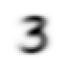

In [17]:
mean3 = stacked_threes.mean(0)
show_image(mean3);

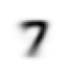

In [18]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

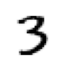

In [19]:
a_3 = stacked_threes[1]
show_image(a_3);

In [20]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [21]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In [22]:
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

## Metrics Calculation

In [23]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [24]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

tensor(0.1114)

In [25]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1270, 0.1410, 0.1109,  ..., 0.1132, 0.1326, 0.1463]),
 torch.Size([1010]))

In [26]:
(valid_3_tens-mean3).shape

torch.Size([1010, 28, 28])

In [27]:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

In [28]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [29]:
is_3(valid_3_tens)

tensor([ True,  True,  True,  ...,  True,  True, False])

In [30]:
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

Over 90% accuracy on both 3's and 7's using a simple baseline model. 

## Loss Function

In [31]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

In [32]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [33]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [34]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

In [35]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [36]:
weights = init_params((28*28,1))

In [37]:
bias = init_params(1)

In [38]:
(train_x[0]*weights.T).sum() + bias

tensor([-6.2330], grad_fn=<AddBackward0>)

In [39]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[ -6.2330],
        [-10.6388],
        [-20.8865],
        ...,
        [-15.9176],
        [ -1.6866],
        [-11.3568]], grad_fn=<AddBackward0>)

In [40]:
corrects = (preds>0.5).float() == train_y
corrects

tensor([[False],
        [False],
        [False],
        ...,
        [ True],
        [ True],
        [ True]])

In [41]:
corrects.float().mean().item()

0.5355759859085083

In [44]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [49]:
weights = init_params((28*28,1))
bias = init_params(1)

In [50]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [51]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [52]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [53]:
preds = linear1(batch)
preds

tensor([[14.0882],
        [13.9915],
        [16.0442],
        [17.7304]], grad_fn=<AddBackward0>)

In [54]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(-14.4636, grad_fn=<MeanBackward0>)

In [55]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(-0.1511), tensor([-1.]))

In [56]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [57]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.3022), tensor([-2.]))

In [58]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.4534), tensor([-3.]))

In [59]:
weights.grad.zero_()
bias.grad.zero_();

In [60]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [61]:
(preds>0.0).float() == train_y[:4]

tensor([[True],
        [True],
        [True],
        [True]])

In [62]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [63]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(1.)

In [64]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [65]:
validate_epoch(linear1)

0.5747

In [66]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.9542

In [67]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.9537 0.9532 0.9532 0.9532 0.9532 0.9532 0.9532 0.9532 0.9532 0.9532 0.9532 0.9532 0.9532 0.9532 0.9532 0.9532 0.9532 0.9532 0.9532 0.9532 

In [68]:
linear_model = nn.Linear(28*28,1)

In [69]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [70]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

In [71]:
opt = BasicOptim(linear_model.parameters(), lr)

In [72]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [73]:
validate_epoch(linear_model)

0.638

In [74]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [75]:
train_model(linear_model, 20)

0.9532 0.9532 0.9532 0.9532 0.9532 0.9532 0.9532 0.9532 0.9532 0.9532 0.9532 0.9532 0.9532 0.9532 0.9532 0.9532 0.9532 0.9532 0.9532 0.9532 

In [76]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.9532 0.9532 0.9532 0.9532 0.9532 0.9532 0.9532 0.9532 0.9532 0.9532 0.9532 0.9532 0.9532 0.9532 0.9532 0.9532 0.9532 0.9532 0.9532 0.9532 

In [77]:
dls = DataLoaders(dl, valid_dl)

In [78]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [79]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,-82.899178,-335.778748,0.953386,00:00
1,-309.272400,-672.095581,0.953386,00:00
2,-570.660339,-1008.412415,0.953386,00:00
3,-854.913818,-1344.729248,0.953386,00:00
4,-1152.343994,-1681.046265,0.953386,00:00
5,-1456.677246,-2017.363037,0.953386,00:00
6,-1764.381836,-2353.679932,0.953386,00:00
7,-2073.650879,-2689.997070,0.953386,00:00
8,-2383.618408,-3026.313477,0.953386,00:00
9,-2693.890869,-3362.630615,0.953386,00:00


In [80]:
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

In [81]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

In [89]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [90]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [92]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,accuracy,time
0,0.075173,0.010845,0.996565,00:26
